# Get started

**Learn the basics of using Q-CTRL Embedded on IBM Quantum services**

## Q-CTRL Embedded on IBM Quantum services overview

Q-CTRL offers a natively integrated performance management option within IBM Quantum services. This option enables you to take advantage of an AI-powered error suppression pipeline directly through Qiskit Runtime on the IBM Quantum Pay-As-You-Go plan at no additional cost! With a single setting, you can maximize the value of quantum compute and obtain high-quality results with less time and less effort.

This tutorial will run through the steps to set up a Qiskit Runtime instance with Q-CTRL Embedded and apply the performance management to a Bernstein–Vazirani circuit. You will be able to compare the performance of the algorithm using Q-CTRL Performance versus the Qiskit Runtime default.

## Setup

### 1. Sign up for an account

You will need to [sign up for an IBM Cloud account](https://cloud.ibm.com/registration) to run this tutorial on quantum hardware resources.

### 2. Create a resource instance with the Q-CTRL Embedded performance management strategy

To use Q-CTRL's error suppression pipeline, you will need to [create a new Qiskit Runtime service instance](https://cloud.ibm.com/catalog/services/quantum-computing). This performance management strategy is offered as part of the Standard plan at no additional cost. The Standard plan is defined as follows:

Standard: A Pay-As-You-Go model for accessing IBM Quantum systems and simulators. Build your own programs and leverage all the benefits of Qiskit Runtime by running on real quantum hardware, while maintaining access to all of the systems available to the Lite plan.

### 3. Install or update Qiskit packages

Install or update the following packages in your development environment. They let you create circuits and work with primitive programs with Qiskit Runtime. For detailed instructions, refer to the [Qiskit install and setup topic](https://docs.quantum-computing.ibm.com/start/install). Periodically check the [Qiskit release notes](https://qiskit.org/documentation/release_notes.html) (or rerun these commands) so that you always have the latest version.

```shell
pip install qiskit qiskit-ibm-runtime -U
```

### 4. Install or update visualization packages
The following packages will be used for visualization and plotting purposes.

```shell
pip install matplotlib qctrl-visualizer
```

### 5. Authenticate to the service with channel strategy set

To enable the performance management strategy, authenticate to the service and call `QiskitRuntimeService` with your IBM Cloud API key, the CRN, and `channel_strategy` set to `"q-ctrl"`. 

To access your credentials:
* Find your API key: From the API keys page, view or create your API key, then copy it to a secure location so you can use it for authentication.
* Find your Cloud Resource Name (CRN): Open the Instances page and click your instance. In the page that opens, click the icon to copy your CRN. Save it in a secure location so you can use it for authentication.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel="ibm_cloud",
    channel_strategy="q-ctrl",
    token="<IBM Cloud API key>",
    instance="<IBM Cloud CRN>",
)

#### 3.1. Save your credentials to disk (optional)

Optionally save your credentials to disk (in the `$HOME/.qiskit/qiskit-ibm.json` file). If you don't save your credentials to disk, you must specify your credentials and set the channel strategy every time you start a new session.

If you save your credentials to disk, you can use `QiskitRuntimeService()` in the future to initialize your account, and Q-CTRL performance management will be enabled by default.

In [ ]:
# Save account to disk and save it as the default.
QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    channel_strategy="q-ctrl",
    token="<IBM Cloud API key>",
    instance="<IBM Cloud CRN>",
    name="q-ctrl",
    set_as_default=True,
)

# Load the saved credentials
service = QiskitRuntimeService(name="q-ctrl")

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(name="q-ctrl")

## Demo: Running the Bernstein–Vazirani algorithm with Q-CTRL performance management

We'll use Q-CTRL performance management to run a Bernstein–Vazirani circuit. This algorithm, used to find a string from the outputs of a black box function, is a common benchmarking algorithm, and it will be used to demonstrate the improvement in performance gained from using Q-CTRL's error suppression.

### 1. Define helper functions

We will start by defining helper functions for processing and plotting the results of our experiments.

In [54]:
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

plt.style.use(qv.get_qctrl_style())


def plot_bv_results(results, hidden_string, title="", max_columns=None):
    """
    Plot a probability histogram and highlight the hidden string.
    """

    # Restrict the number of columns displayed.
    if max_columns is not None:
        top_strings = sorted(results.keys(), key=lambda x: results[x], reverse=True)[
            :max_columns
        ]
        if hidden_string not in top_strings:
            top_strings.append(hidden_string)
        results = {s: results[s] for s in top_strings}

    bitstrings = sorted(results.keys())

    def to_probability(value, total):
        if isinstance(value, float):
            return value
        return value / total

    probabilities = [to_probability(results[b], shot_count) for b in bitstrings]
    plt.figure(figsize=(20, 5))
    bars = plt.bar(bitstrings, probabilities)
    plt.xticks(rotation=90)

    for index, bitstring in enumerate(bitstrings):
        if bitstring != hidden_string:
            bars[index].set_color("grey")

    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.title(title)
    plt.show()


def bitstring_count_to_probabilities(data, shot_count, number_of_counting_qubits):
    """
    Process the results.
    This function turns a dictionary of bitstring counts into a dictionary
    of probabilities.
    """
    probabilities = {
        format(int(bitstring, 2), f"0{number_of_counting_qubits}b"): (
            bitstring_count / shot_count
        )
        for bitstring, bitstring_count in data.items()
    }

    return probabilities

### 2. Provide the quantum circuit

Here, we will define the hidden string, the correct answer to the algorithm, and the Bernstein–Vazirani circuit.

In [24]:
import qiskit

hidden_bitstring = "11111111111"

input_size = len(hidden_bitstring)

# Create circuit, reserving one qubit for BV oracle.
circuit_qis = qiskit.QuantumCircuit(input_size + 1, input_size)

# Put ancilla in state |1⟩.
circuit_qis.x(input_size)

# Apply Hadamard to all qubits (including ancilla).
circuit_qis.h(range(input_size + 1))

# Apply oracle.
circuit_qis.barrier()
for input_qubit, bit in enumerate(reversed(hidden_bitstring)):
    if bit == "1":
        circuit_qis.cx(input_qubit, input_size)

# Apply Hadamard to all qubits (including ancilla).
circuit_qis.barrier()
circuit_qis.h(range(input_size + 1))

# Measure all data qubits.
circuit_qis.barrier()
for input_qubit in range(input_size):
    circuit_qis.measure(input_qubit, input_qubit)

circuit_qis.draw(fold=-1)

┌───┐      ░                                                         ░ ┌───┐ ░ ┌─┐                              
 q_0: ┤ H ├──────░───■─────────────────────────────────────────────────────░─┤ H ├─░─┤M├──────────────────────────────
      ├───┤      ░   │                                                     ░ ├───┤ ░ └╥┘┌─┐                           
 q_1: ┤ H ├──────░───┼────■────────────────────────────────────────────────░─┤ H ├─░──╫─┤M├───────────────────────────
      ├───┤      ░   │    │                                                ░ ├───┤ ░  ║ └╥┘┌─┐                        
 q_2: ┤ H ├──────░───┼────┼────■───────────────────────────────────────────░─┤ H ├─░──╫──╫─┤M├────────────────────────
      ├───┤      ░   │    │    │                                           ░ ├───┤ ░  ║  ║ └╥┘┌─┐                     
 q_3: ┤ H ├──────░───┼────┼────┼────■──────────────────────────────────────░─┤ H ├─░──╫──╫──╫─┤M├─────────────────────
      ├───┤      ░   │    │    │    │                                      ░ ├───┤ ░  ║  ║  ║ └╥┘┌─┐                  
 q_4: ┤ H ├──────░───┼────┼────┼────┼────■─────────────────────────────────░─┤ H ├─░──╫──╫──╫──╫─┤M├──────────────────
      ├───┤      ░   │    │    │    │    │                                 ░ ├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐               
 q_5: ┤ H ├──────░───┼────┼────┼────┼────┼────■────────────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫─┤M├───────────────
      ├───┤      ░   │    │    │    │    │    │                            ░ ├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────■───────────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫─┤M├────────────
      ├───┤      ░   │    │    │    │    │    │    │                       ░ ├───┤ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────■──────────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├─────────
      ├───┤      ░   │    │    │    │    │    │    │    │                  ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────■─────────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────
      ├───┤      ░   │    │    │    │    │    │    │    │    │             ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────■────────░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤      ░   │    │    │    │    │    │    │    │    │    │        ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ┤ H ├──────░───┼────┼────┼────┼────┼────┼────┼────┼────┼────┼────■───░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐ ░ ├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
q_11: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘└───┘ ░ └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ░ └───┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ 
c: 11/════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                                                                      0  1  2  3  4  5  6  7  8  9  10

### 3. Execute the circuit using Q-CTRL performance management

In the absence of hardware noise, only a single experiment would be required to obtain the correct hidden string: `111 111 111 11`. However in real quantum hardware, noise disturbs the state of the system and degrades performance, decreasing the probability of obtaining the correct answer for any single experiment. Fire Opal automates the adjustments made by experts when running circuits on a real device.

First, specify the device that you'll use to run the circuit. Currently, Q-CTRL performance management is only supported on IBM Algiers, a 27-qubit device. Support for additional 127-qubit devices is coming soon!

In [25]:
backend_name = "ibm_algiers"

Next, submit the circuit using Qiskit Runtime's sampler primitive. Because the channel strategy was previously set on both resource instance creation and service initialization, the primitives, Sampler and Estimator, will automatically apply Q-CTRL's performance management to suppress errors.

**_Note: Once jobs are submitted, there may be a delay in returning results due to the hardware provider's queue._** 

In [75]:
service = QiskitRuntimeService(name="q-ctrl")

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

shot_count = 2048

backend = service.backend(backend_name)

sampler = Sampler(backend=backend)

q_ctrl_result = sampler.run([circuit_qis], shots=shot_count).result()
q_ctrl_probabilities = bitstring_count_to_probabilities(
    q_ctrl_result.data.c.get_counts(), shot_count, input_size
)

Once the results have been returned from the device, you can plot the results and calculate the success probability, which estimates the probability that a single execution (shot) of the circuit will yield a solution.

Success probability: 46.19%


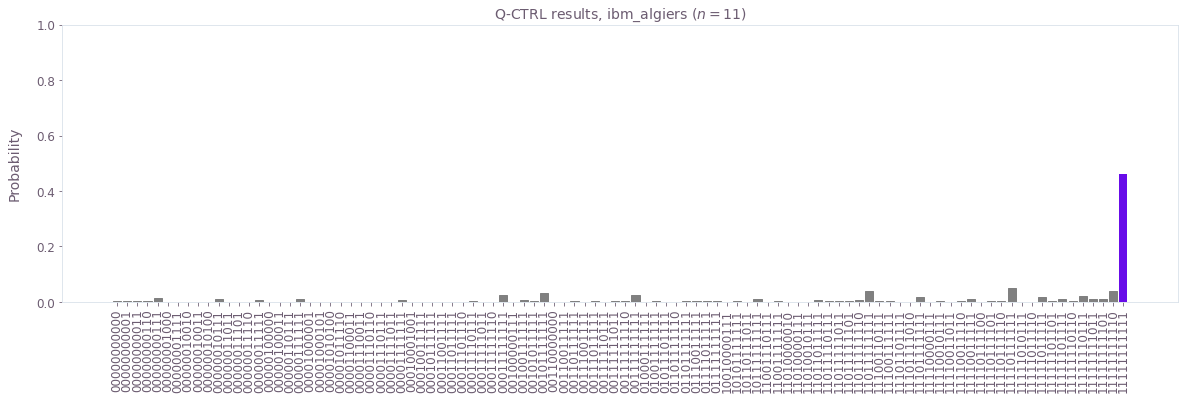

In [79]:
print(f"Success probability: {100 * q_ctrl_probabilities[hidden_bitstring]:.2f}%")
plot_bv_results(
    q_ctrl_probabilities,
    hidden_string=hidden_bitstring,
    title=f"Q-CTRL results, {backend_name} ($n=11$)",
    max_columns=100,
)

With Q-CTRL's performance management, errors in hardware execution that typically impact accuracy are suppressed. Therefore, you can expect to get an improved success probability compared to results where error suppression was not applied. In some cases, you can even obtain better results than those that you'd achieve using the default levels of error suppression and mitigation built into Qiskit Runtime primitives.

In the following section, you can compare the results that you obtained with Q-CTRL's performance management to those that you get from using the default Sampler settings.

### 4. Compare results with default Qiskit Runtime settings

To get a true comparison, we'll run the same circuit using Qiskit Runtime's default Sampler settings on the same IBM backend as used previously to get a one-to-one comparison.

To revert back to the default Qiskit Runtime behavior, you will need to copy the CRN of an existing instance that does not have Q-CTRL performance management or [create a new Qiskit Runtime service instance](https://cloud.ibm.com/catalog/services/quantum-computing). During this creation process, do not select the Q-CTRL performance management strategy.

Next, authenticate to the service using the CRN, and do not set `channel_strategy="q-ctrl`. If you try to use this setting on an instance without Q-CTRL, you should receive an error.

In [ ]:
# use the CRN of the instance without Q-CTRL performance management
# do not set a channel_strategy
service = QiskitRuntimeService(
    channel="ibm_cloud", token="<IBM Cloud API key>", instance="<IBM Cloud CRN>"
)

Now run the circuit once again using the Sampler. Since the resource instance used now does not have Q-CTRL performance management set, the Sampler will automatically apply the default [error suppression and mitigation settings](https://docs.quantum-computing.ibm.com/run/advanced-runtime-options) (`optimization_level=1` and `resilience_level=1`).

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend = service.backend(backend_name)
sampler = Sampler(backend=backend)

default_result = sampler.run([circuit_qis], shots=shot_count).result()
default_probabilities = bitstring_count_to_probabilities(
    default_result.data.c.get_counts(), shot_count, input_size
)

Success probability: 14.67%


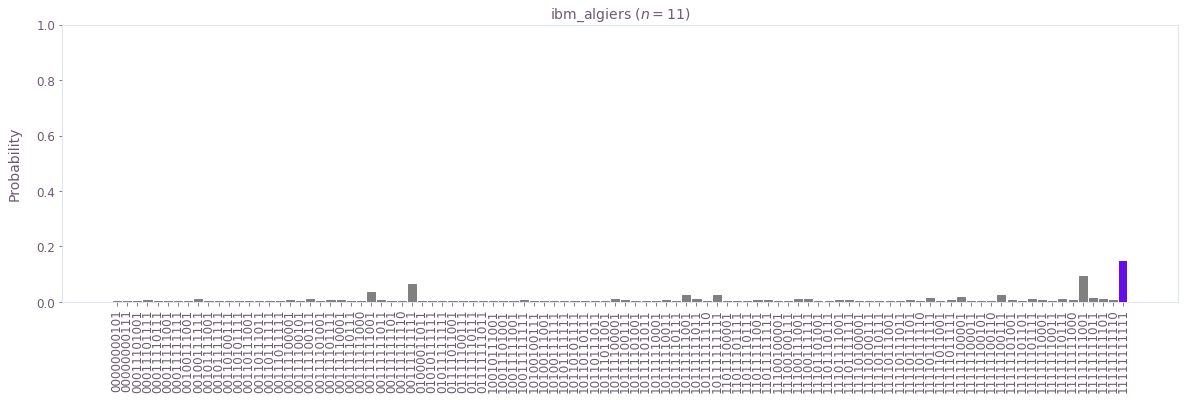

In [65]:
print(f"Success probability: {100 * default_probabilities[hidden_bitstring]:.2f}%")
plot_bv_results(
    default_probabilities,
    hidden_string=hidden_bitstring,
    title=f"{backend_name} ($n=11$)",
    max_columns=100,
)

The above results demonstrate that noise has severely impacted the probability of obtaining the correct hidden string as the output. In this case, the string returned with the greatest frequency by the quantum computer was not the expected `111 111 111 11` state. We should also take note of the amount of incorrect states that now contain non-zero return probabilities. Not only do default configurations fail to find the correct answer, they also increase the probabilities of the incorrect answers.

You can tell that the correct answer was found in the execution run conducted using Q-CTRL performance management, because the mode of the output distribution, or the most frequent outcome, matches the desired output: bitstring `111 111 111 11`. Q-CTRL significantly improves the probability of a successful outcome, often by a factor of ten or more.

In [80]:
q_ctrl_success = q_ctrl_probabilities[hidden_bitstring]
default_success = default_probabilities[hidden_bitstring]
factor = int(q_ctrl_success / default_success)
print(
    f"Q-CTRL performance management improved success probability by a factor of {factor}!"
)

Q-CTRL performance management improved success probability by a factor of 3!


Congratulations! You've run your first algorithm with using Q-CTRL's natively integrated error suppression on IBM Quantum platform. Performance management can be an effective way of improving the accuracy of an algorithm and unlocking even greater value from your quantum stack.